In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.parse

def str_url_format(word):
    return (urllib.parse.unquote(word)
                .replace("_", " ")
                .strip())
    
# Graph is defined in file `links.tsv`
df = (pd.read_csv("wikispeedia/wikispeedia_paths-and-graph/links.tsv", 
                  skiprows=12, 
                  sep="\t", 
                  header=None)
      .applymap(str_url_format)
      .applymap(str.strip)
      .rename(columns={0:"out",
                       1:"in"})
     )

df.sample(5)

,out,in
9406,Art,Aesthetics
61802,La Grande Armée,British Isles
52704,Human,Weapon
60614,Kazakhstan,Persian Empire
6466,Ancient Greece,Roman Greece


In [92]:
# Describe df

print(f"There are {df.shape[0]} edges")
print(f"connecting {df.stack().nunique()} unique nodes in the network.")
print(f"\n\t * {df['out'].nunique()} nodes have out-links.")
print(f"\t * {df['in'].nunique()} nodes have in-links.\n")

print(f"This means {df.stack().nunique() - df['out'].nunique()} nodes are dead-ends (no out-links),")
print(f"and {df.stack().nunique() - df['in'].nunique()} \
nodes can never be reached from any other article (no in-links) ☠️")

There are 119882 edges
connecting 4592 unique nodes in the network.

	 * 4587 nodes have out-links.
	 * 4135 nodes have in-links.

This means 5 nodes are dead-ends (no out-links),
and 457 nodes can never be reached from any other article (no in-links) ☠️


In [93]:
# nodes with no outlink (dead-ends)
nodes_no_outlink = (set(df.stack()
                        .unique())
                    .difference(df['out']
                                .unique()))
print(len(nodes_no_outlink))
nodes_no_outlink

5


{'Directdebit',
 'Duchenne muscular dystrophy',
 "Klinefelter's syndrome",
 'Local community',
 'Osteomalacia'}

In [94]:
# Let's see which articles can't be reached from any other
nodes_no_inlink = list((set(df.stack()
                            .unique())
                        .difference(df['in']
                                    .unique())))
print(len(nodes_no_inlink))

nodes_no_inlink[:5]

457


['Kipchaks in Georgia',
 'Project MKULTRA',
 'Winfield Scott (ship)',
 'Btrieve',
 'Terik']

### All these nodes can only be visited if they're selected as starting point.

---

In [95]:
freq_out = df['out'].value_counts()
freq_in = df['in'].value_counts()

degree_freq = (pd.merge(freq_in,
                        freq_out, 
                        left_index=True, 
                        right_index=True, 
                        how='inner')  #exclude zeros
               .fillna(0))

degree_freq.head()

,in,out
United States,1551,294
United Kingdom,972,168
France,959,85
Europe,933,159
England,751,172


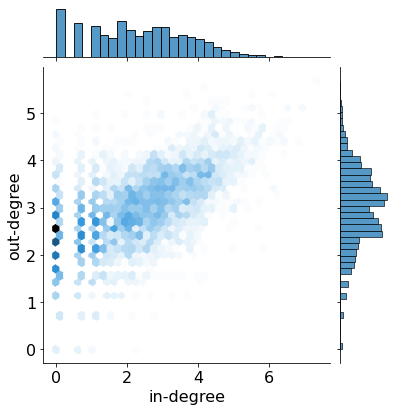

In [96]:
g = sns.jointplot(data=np.log(degree_freq), 
                  x="in", y="out", 
                  kind='hex')

g.ax_joint.set_xlabel("in-degree")
g.ax_joint.set_ylabel("out-degree");

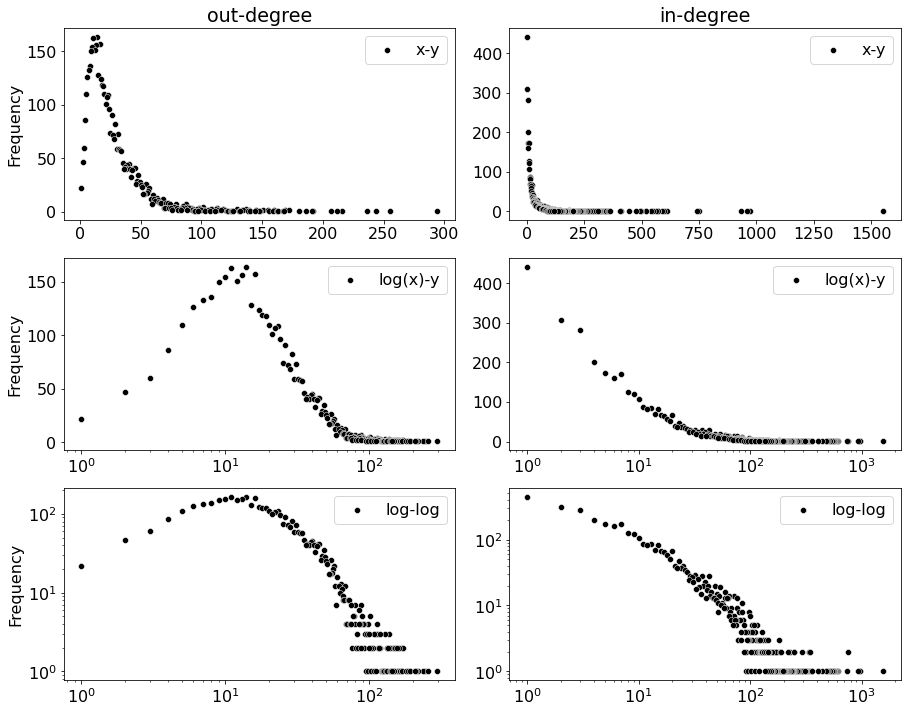

In [97]:
plt.rcParams['font.size'] = 16

fig, ax = plt.subplots(3,2,
                       figsize=(15,12),
                       gridspec_kw={'wspace':0.14})

labels = ["x-y", "log(x)-y", "log-log"]
for i in range(3):
    sns.scatterplot(data = df['out'].value_counts().value_counts(), 
                    ax=ax[i,0], color='k', label=labels[i])
    sns.scatterplot(data = df['in'].value_counts().value_counts(), 
                    ax=ax[i,1], color='k', label=labels[i])

ax[0, 0].set_title("out-degree")
ax[0, 1].set_title("in-degree")

for i in range(2):
    # Set log scale in x for second row plots
    ax[1,i].set_xscale('log')
    # log-log scale in 3rd row
    ax[2,i].set_xscale('log')
    ax[2,i].set_yscale('log')
    
for i in range(3):
    ax[i, 0].set_ylabel("Frequency")
    ax[i, 1].set_ylabel("")
    
plt.legend();

### Distributions of in- and out- degree are very different.

- in-degree distribution is more power-law-like. The lowest the in-degree, the higher frequency.
- out-degree has a more likely value of around 15. 

# TODO

- Distribution of in-links and out-links per node
- Test hypothesis: visit frequency correlates with node in-degree.

In [98]:
# Ukraine_A is not in this df (meaning no link points to it)
degree_freq[degree_freq.index.str.startswith("Ukraine")]

,in,out
Ukraine,171,58


# Load actual paths. Check frequency

In [100]:
def split_decode_path(path):
    pathl = (path.replace("_", " ")
             .strip()
             .split(";"))
    return list(map(
        urllib.parse.unquote, 
        pathl
    ))

df_paths_success = (pd.read_csv("wikispeedia/wikispeedia_paths-and-graph/paths_finished.tsv", 
                          skiprows=15, 
                          sep="\t", 
                          header=None)
                    .rename(columns={0:"ip",
                                     1:"timestamp",
                                     2:"duration",
                                     3:"path",
                                     4:"rating"})
         )
# Create a "target" col
df_paths_success["target"] = (df_paths_success["path"]
                              .apply(lambda x: str_url_format(x).split(";")[-1]))
df_paths_success["type"] = "win"


df_paths_fail = (pd.read_csv("wikispeedia/wikispeedia_paths-and-graph/paths_unfinished.tsv", 
                             skiprows=16, 
                             sep="\t", 
                             header=None)
                 .rename(columns={0:"ip",
                                  1:"timestamp",
                                  2:"duration",
                                  3:"path",
                                  4:"target",
                                  5:"type"})
             )

# Join dfs to get a full df with all paths
df_paths = pd.concat([df_paths_success,
                      df_paths_fail])

# Get path list
df_paths["pathl"] = df_paths["path"].apply(split_decode_path)
# Decode target from url
df_paths["target"] = df_paths["target"].apply(str_url_format)
# Get starting node
df_paths["start"] = df_paths["pathl"].apply(lambda x:x[0])

df_paths.sample(5)

,ip,timestamp,duration,path,rating,target,type,pathl,start
530,3c6c6e5715e633c1,1298664418,140,Arab-Israeli_conflict;United_States;George_W._...,NaN,Beer,restart,"[Arab-Israeli conflict, United States, George ...",Arab-Israeli conflict
598,1ea2dbdb11d2c8bf,1298676545,1879,Hovercraft;English_Channel;Channel_Islands;Vic...,NaN,Whooping Crane,timeout,"[Hovercraft, English Channel, Channel Islands,...",Hovercraft
49643,64ed71b54d998504,1257898814,133,Tsar_Bomba;Russian_language;Russia;Leon_Trotsky,2.0,Leon Trotsky,win,"[Tsar Bomba, Russian language, Russia, Leon Tr...",Tsar Bomba
28414,6b773354121cccb3,1250924024,191,Kuwait;Agriculture;Fossil_fuel;Natural_gas;Ear...,NaN,Pluto,win,"[Kuwait, Agriculture, Fossil fuel, Natural gas...",Kuwait
49670,68c9826f016b0a60,1331575390,33,Tufted_Duck;United_States;President_of_the_Uni...,1.0,William Henry Harrison,win,"[Tufted Duck, United States, President of the ...",Tufted Duck


# Selection of starting and ending nodes: Is it uniformly distributed?

In [101]:
degree_freq_ = (pd.merge(degree_freq,
                       pd.DataFrame(
                           df_paths["target"]
                           .value_counts()
                       ),
                        left_index=True,
                        right_index=True,
                        how="outer"
                      ))

degree_freq_

,in,out,target
1 Ceres,12.0,32.0,11.0
10th century,65.0,26.0,7.0
11th century,57.0,48.0,13.0
12th century,85.0,45.0,10.0
13th century,84.0,34.0,34.0
...,...,...,...
Zirconium,15.0,42.0,21.0
Zoroaster,9.0,28.0,5.0
Zuid-Gelders,5.0,5.0,11.0
Zulu,14.0,15.0,9.0


In [102]:
degree_freq_.loc["Zebra shark"]

in         1.0
out        9.0
target    28.0
Name: Zebra shark, dtype: float64

In [58]:
pd.DataFrame(df_paths["start"].value_counts())

,start
Brain,2113
Theatre,1823
Asteroid,1804
Pyramid,1627
Batman,947
...,...
Outer_Hebrides,1
David_Heymann,1
Hurricane_John_(1994),1
Psittacosaurus,1


In [55]:
degree_freq

,in,out
United_States,1551,294
United_Kingdom,972,168
France,959,85
Europe,933,159
England,751,172
...,...,...
History_of_Greenland,1,37
History_of_Arizona,1,50
History_of_Alaska,1,30
Ateneo_de_Manila_University,1,16
